In [1]:
!pip install datasets soundfile speechbrain accelerate
!pip install torch==2.7.0+cu126 torchaudio==2.7.0 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers soundfile

Looking in indexes: https://download.pytorch.org/whl/cu126


In [2]:
import torch, torchaudio
import transformers
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
import io

from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Audio
from tqdm import tqdm

In [3]:
print(torch.__version__)
print("Transformers version:", transformers.__version__)

2.7.0+cu126
Transformers version: 4.57.3


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print("CUDA is available")
else:
    print("CUDA is not available")  

CUDA is available


In [5]:
dataset = load_dataset("openslr/librispeech_asr", "clean", split="train.100[:3000]")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000, decode=False))

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

In [6]:
dataset[0]

{'file': '/home/albert/.cache/huggingface/datasets/downloads/extracted/bc0d9a6ef85c2d487c9c6efbc91f8892df927c69d3f80545a668cc058d5f677e/374-180298-0000.flac',
 'audio': {'bytes': b'fLaC\x00\x00\x00"\x10\x00\x10\x00\x00\x04\xa4\x00\x16\xc5\x03\xe8\x00\xf0\x00\x03\x8c \xbc\x9b)\\H\xbe6\xbe\xc0\xad\xc8H\x9a\xa8N^\x03\x00\x00$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x02p\x00\x00\x00\x00\x00\x00\x02j\xeb\x10\x00\x04\x00\x00( \x00\x00\x00reference libFLAC 1.2.1 20070917\x00\x00\x00\x00\x81\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [7]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1
print(speaker_counts)

defaultdict(<class 'int'>, {374: 113, 7800: 115, 2514: 108, 3240: 127, 1088: 112, 5456: 112, 5750: 122, 1246: 117, 8238: 123, 1263: 109, 7505: 115, 587: 117, 226: 107, 1743: 103, 4214: 81, 5789: 112, 7635: 122, 5390: 116, 307: 124, 7447: 114, 4362: 107, 6529: 107, 233: 110, 3242: 123, 1624: 101, 4297: 111, 6181: 72})


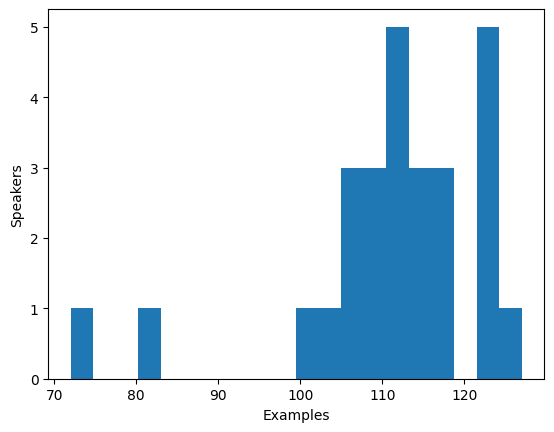

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [9]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])
print(f"Number of Speakers: {len(set(dataset['speaker_id']))}")
print(f"Number of Samples: {len(dataset)}")

Number of Speakers: 25
Number of Samples: 2847


In [10]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
import torch

model_name = "microsoft/speecht5_tts"

# load model/processor
processor = SpeechT5Processor.from_pretrained(model_name)
model = SpeechT5ForTextToSpeech.from_pretrained(model_name).to(device)

In [11]:
# remove audio clips under 3 seconds
def audio_long_enough(audio):
    with io.BytesIO(audio["bytes"]) as f:
        audio_array, _ = sf.read(f)
    return len(audio_array) >= 48000 


def is_not_too_long(batch):
    tokens = processor.tokenizer(batch["text"]) # tokenize
    return len(tokens["input_ids"]) < 200

dataset = dataset.filter(audio_long_enough, input_columns=["audio"])
dataset = dataset.filter(is_not_too_long)
len(dataset)

1307

In [12]:
# limir samples per speaker
SAMPLES_PER_SPEAKER = 20
samples_taken = defaultdict(int)

def samples_per_speaker(speaker_id):
    if samples_taken[speaker_id] < SAMPLES_PER_SPEAKER:
        samples_taken[speaker_id] += 1
        return True
    return False

dataset = dataset.filter(samples_per_speaker, input_columns=["speaker_id"])
print(f"Final Dataset Size: {len(dataset)}")

Final Dataset Size: 498


In [13]:
import os
import torch
from speechbrain.inference.classifiers import EncoderClassifier
from accelerate import Accelerator

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
device = Accelerator().device
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

C:\Users\Irfan\miniconda3\envs\voiceclone\lib\site-packages\speechbrain\utils\autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
C:\Users\Irfan\miniconda3\envs\voiceclone\lib\inspect.py:746: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\Irfan\miniconda3\envs\voiceclone\lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(


In [14]:
unique_speakers = sorted(list(set(dataset['speaker_id'])))
speaker2idx = {original_id: i for i, original_id in enumerate(unique_speakers)}
num_speakers = len(unique_speakers)

# map indexes from 0 to number of unique speakers
def map_speaker_ids(example):
    example['speaker_idx'] = speaker2idx[example['speaker_id']]
    return example
dataset = dataset.map(map_speaker_ids)

print(f"Mapped {num_speakers} speakers to indices 0-{num_speakers-1}")

Mapped 25 speakers to indices 0-24


In [15]:
def prepare_dataset(example):
    print(example["audio"]["path"])
    with io.BytesIO(example["audio"]["bytes"]) as f:
        audio_array, sr = sf.read(f)

    example = processor(
        text=example["text"],
        audio_target=audio_array,
        sampling_rate=sr,
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio_array)

    return example

In [16]:
cols_to_remove = ["audio", "file", "text", "speaker_id", "chapter_id", "id"]
dataset = dataset.map(prepare_dataset, remove_columns=cols_to_remove)

In [17]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

498

In [18]:
from datasets import ClassLabel
# dataset = dataset.train_test_split(test_size=0.1)

dataset = dataset.cast_column("speaker_idx", ClassLabel(num_classes=25))
dataset = dataset.train_test_split(test_size=0.1, stratify_by_column="speaker_idx")
print("Unique speakers in Test:", len(set(dataset['test']['speaker_idx'])))

Unique speakers in Test: 25


In [19]:
dataset['train']

Dataset({
    features: ['speaker_idx', 'input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 448
})

In [20]:
import torch.nn as nn

all_indices = torch.tensor(dataset['train']['speaker_idx']).to(device)
all_embeddings = torch.tensor(dataset['train']['speaker_embeddings']).to(device)

# sum all embeddings for each speaker index
embedding_sums = torch.zeros(num_speakers, 512).to(device)
embedding_sums.index_add_(0, all_indices, all_embeddings)

# count samples per speaker
counts = torch.bincount(all_indices, minlength=num_speakers).float().unsqueeze(1).to(device)
counts = counts.clamp(min=1.0) # avoid division by zero

# calculate averages and add to speaker bank
average_embeddings = embedding_sums / counts
speaker_bank = nn.Embedding.from_pretrained(average_embeddings, freeze=False) # create embedding layer

print("Speaker bank initialized.")

Speaker bank initialized.


In [21]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: list[dict[str, Union[list[int], torch.Tensor]]]) -> dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]

        ### collect speaker indicies ###
        speaker_indices = [feature["speaker_idx"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        ### add speaker indicies to batch ###
        batch["speaker_idxs"] = torch.tensor(speaker_indices, dtype=torch.long)

        return batch

In [22]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [23]:
# freeze model parameters
for param in model.parameters():
    param.requires_grad = False
model.eval() # disable dropout

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

### Fine-Tune Embedding

In [25]:
lr = 1e-4
num_epochs = 10
batch_size = 8
optimizer = torch.optim.AdamW(speaker_bank.parameters(), lr=lr)

train_loader = DataLoader(
    dataset['train'],
    batch_size=batch_size,
    shuffle=True, 
    collate_fn=data_collator
)
print("Optimizing speaker embeddings...")

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        speaker_idxs = batch["speaker_idxs"].to(device)

        optimizer.zero_grad()
        
        # get embeddings for speaker
        current_embeddings = speaker_bank(speaker_idxs)
        
        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            speaker_embeddings=current_embeddings,
            labels=labels
        )
        loss = outputs.loss
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.5f}")

# save the bank
torch.save(speaker_bank.state_dict(), "speaker_embeddings_ft.pt")
print("Training Complete.")

Optimizing speaker embeddings...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:10<00:00,  1.25s/it, loss=0.5140]


Epoch 1 Average Loss: 0.50797


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:06<00:00,  1.19s/it, loss=0.5451]


Epoch 2 Average Loss: 0.50395


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:10<00:00,  1.25s/it, loss=0.5183]


Epoch 3 Average Loss: 0.50085


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:05<00:00,  1.17s/it, loss=0.5232]


Epoch 4 Average Loss: 0.49834


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:08<00:00,  1.22s/it, loss=0.4941]


Epoch 5 Average Loss: 0.49841


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:05<00:00,  1.16s/it, loss=0.4664]


Epoch 6 Average Loss: 0.49471


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:06<00:00,  1.19s/it, loss=0.4787]


Epoch 7 Average Loss: 0.49614


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:12<00:00,  1.29s/it, loss=0.5542]


Epoch 8 Average Loss: 0.49565


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:02<00:00,  1.12s/it, loss=0.5344]


Epoch 9 Average Loss: 0.49377


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:13<00:00,  1.30s/it, loss=0.4559]

Epoch 10 Average Loss: 0.49164
Training Complete.


In [26]:
test_sample = dataset['test'][0]
speaker_idx_val = test_sample['speaker_idx']
# decode text
tokens = processor.batch_decode(test_sample["input_ids"])
text = "".join([" " if t == "" else t for t in tokens if t != "</s>"])[1:]
print(text)

# original vs fine-tuned embeddings
original_emb = torch.tensor(test_sample['speaker_embeddings']).to(device).unsqueeze(0)
tuned_emb = speaker_bank(torch.tensor(speaker_idx_val).to(device)).unsqueeze(0) # get embedding for specific speaker

print(f"Comparing Speaker Index: {speaker_idx_val}")
print(f"Original Embedding Norm: {torch.norm(original_emb).item():.4f}")
print(f"Tuned Embedding Norm:    {torch.norm(tuned_emb).item():.4f}")

OVER THERE HE COMES BACKWARDS AND FORWARDS EVERY WEEK DOESN'T HE NOT QUITE THAT I BELIEVE I SHALL MISS HER IF SHE HAS TO STAY AWAY LONG I KNOW YOU DON'T LIKE HER I DO LIKE HER
Comparing Speaker Index: 13
Original Embedding Norm: 1.0000
Tuned Embedding Norm:    0.9922


In [27]:
inputs = processor(text=text, return_tensors="pt").to(device)

# spectrogram comparison
spec_ground_truth = torch.tensor(test_sample["labels"]).to(device)
spec_orig = model.generate_speech(inputs["input_ids"], original_emb)
spec_tuned = model.generate_speech(inputs["input_ids"], tuned_emb)

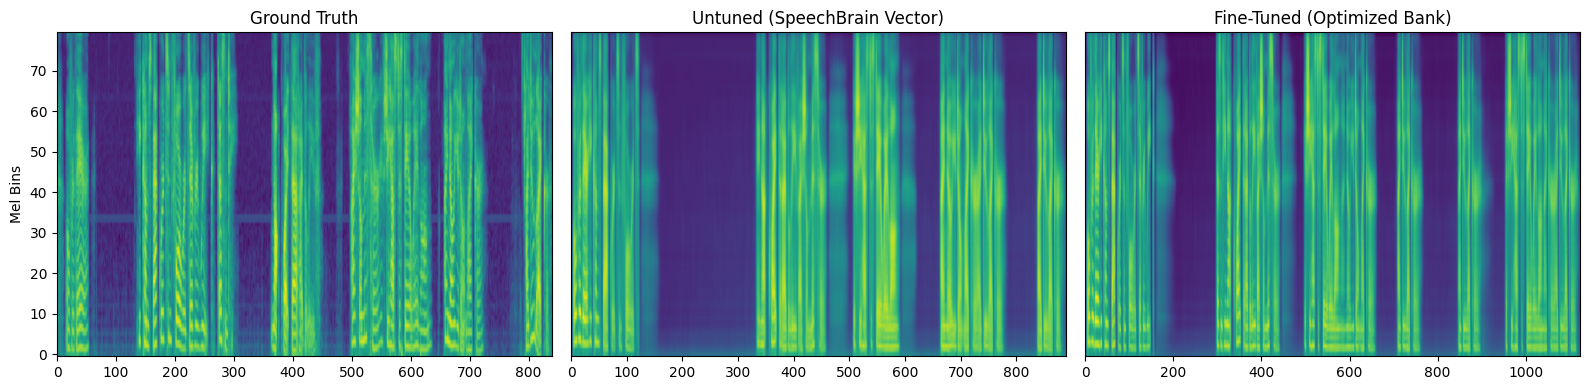

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# ground truth
axs[0].imshow(spec_ground_truth.cpu().T, origin="lower", aspect="auto")
axs[0].set_title("Ground Truth")
axs[0].set_ylabel("Mel Bins")

# original embedding
axs[1].imshow(spec_orig.cpu().T, origin="lower", aspect="auto")
axs[1].set_title("Untuned (SpeechBrain Vector)")
axs[1].set_yticks([])

# fine-tuned embedding
axs[2].imshow(spec_tuned.cpu().T, origin="lower", aspect="auto")
axs[2].set_title("Fine-Tuned (Optimized Bank)")
axs[2].set_yticks([])

plt.tight_layout()
plt.show()

In [29]:
from IPython.display import Audio
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

print("Playing Original Ground Truth Audio:")
ground_truth_audio = vocoder(spec_ground_truth.unsqueeze(0))
Audio(ground_truth_audio.detach().cpu().numpy(), rate=16000)

Playing Original Ground Truth Audio:


In [30]:
print("Playing SpeechBrain Version:")
orig_audio = vocoder(spec_orig.unsqueeze(0))
Audio(orig_audio.detach().cpu().numpy(), rate=16000)

Playing SpeechBrain Version:


In [31]:
print("Playing Tuned Version:")
tuned_audio = vocoder(spec_tuned.unsqueeze(0))
Audio(tuned_audio.detach().cpu().numpy(), rate=16000)

Playing Tuned Version:
